# Imports/Set up

In [1]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import math
import sys

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import count_model_params
from neuralop.utils import get_project_root
from torch.utils.data import DataLoader

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


# Train FNO At Different Resolutions

In [2]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 


In [3]:
# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor

In [4]:
df = pd.DataFrame(
    columns=['train_resolution', 'test_resolution', 'loss_type', 'loss'],
)
trained_models = {}  # at different resolutions
for train_resolution in [16, 32, 64, 128]:
    # get data
    train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000,
        # batch_size=16,
        train_resolution=train_resolution,
        test_resolutions=[16, 32, 64, 128],
        n_tests=[100, 100, 100, 100],
        # test_batch_sizes=[32, 32, 32, 32],
    )

    # incrementally vary modes
    incremental = True
    starting_modes = (16, 16)
    if incremental:
        starting_modes = (2, 2)

    # Set up model
    model = FNO(
        max_n_modes=(16, 16),
        n_modes=starting_modes,
        hidden_channels=32,
        in_channels=1,
        out_channels=1,
    )
    model = model.to(device)
    n_params = count_model_params(model)

    # optimizer + data
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    data_transform = IncrementalDataProcessor(
        in_normalizer=None,
        out_normalizer=None,
        device=device,
        subsampling_rates=[2, 1],
        dataset_resolution=16,
        dataset_indices=[2, 3],
        epoch_gap=10,
        verbose=True,
    )

    data_transform = data_transform.to(device)

    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    train_loss = h1loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}
    print('\n### N PARAMS ###\n', n_params)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # Finally pass all of these to the Trainer
    trainer = IncrementalFNOTrainer(
        model=model,
        n_epochs=20,
        data_processor=data_transform,
        device=device,
        verbose=False,
        incremental_loss_gap=False,
        incremental_grad=True,
        incremental_grad_eps=0.9999,
        incremental_loss_eps=0.001,
        incremental_buffer=5,
        incremental_max_iter=1,
        incremental_grad_max_iter=2,
    )

    # train
    end_stats = trainer.train(
        train_loader,
        test_loaders,
        optimizer,
        scheduler,
        regularizer=False,
        training_loss=train_loss,
        eval_losses=eval_losses,
    )

    trained_models[train_resolution] = trainer.model

    # save stats
    for k, v in end_stats.items():
        s = k.split('_')

        if 'h1' in s or ('l2' in s):
            row = {
                'train_resolution': train_resolution,
                'test_resolution': s[0],
                'loss_type': s[1],
                'loss': v.item(),
            }
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f767ce880a0>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f767ce880a0>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f770064ce50>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


/tmp/ipykernel_260125/2828161396.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f74f30120b0>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f74f30120b0>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f74f3011c00>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16
Loading test db for resolution 16 with 100 samples 
Loading test db 

Text(0.5, 1.0, 'Training resolution affect on Test Performance')

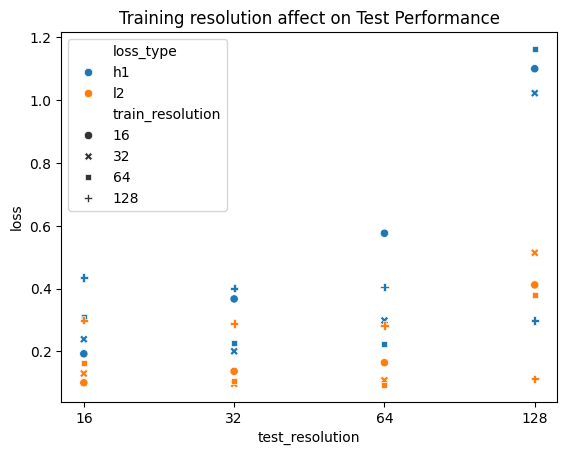

In [5]:
sns.scatterplot(
    data=df,
    x='test_resolution',
    y='loss',
    hue='loss_type',
    style='train_resolution',
)
plt.title('Training resolution affect on Test Performance')

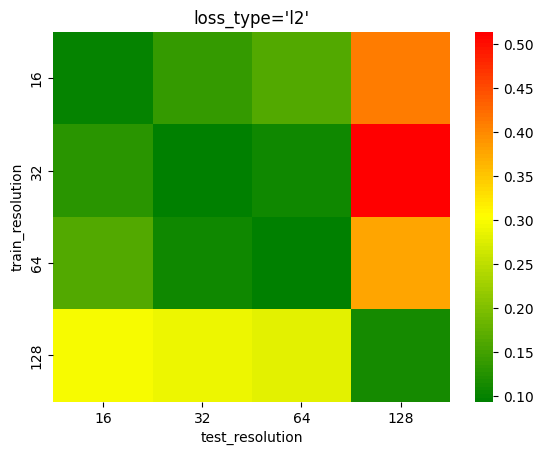

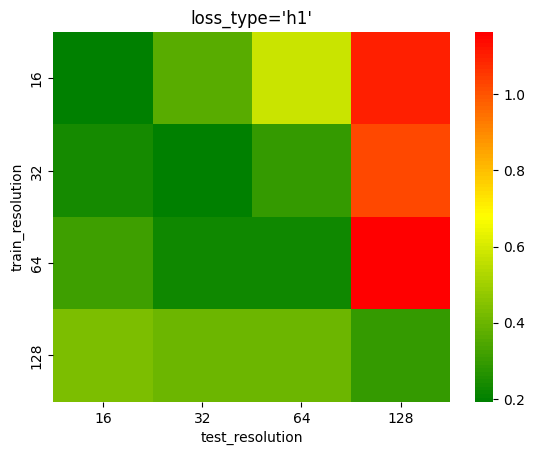

In [6]:
# Define colormap from green (high engagement) to red (low engagement)
cmap = mcolors.LinearSegmentedColormap.from_list(
    'green_red',
    ['green', 'yellow', 'red'],
    N=100,
)
for loss_type in ['l2', 'h1']:
    heat = df[df.loss_type == loss_type].pivot(
        index='train_resolution',
        columns='test_resolution',
        values='loss',
    )
    heat = heat.loc[:, ['16', '32', '64', '128']]
    sns.heatmap(heat, cmap=cmap)
    plt.title(f'{loss_type=}')
    plt.show()

# Visualize Loss on Different Frequencies

Model trained on resolution of 16 x 16 and evaluated on 128 x 128 data

In [15]:
# install a filtering library and include a versioning work around
%pip install hdaf-filter==0.1.1

# Monkeypatch
import numpy as np
from scipy.special import factorial

np.math = type('math', (), {})()
np.math.factorial = factorial

Note: you may need to restart the kernel to use updated packages.


--2025-05-30 18:21:17--  https://github.com/paul-hernandez-herrera/hdaf_filtering/raw/03e58207ecc8c011b66325dc1e60912dd372ead8/test_data/2d/Cells_01.tif
Resolving github.com (github.com)... 140.82.112.3
connected. to github.com (github.com)|140.82.112.3|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/paul-hernandez-herrera/hdaf_filtering/03e58207ecc8c011b66325dc1e60912dd372ead8/test_data/2d/Cells_01.tif [following]
--2025-05-30 18:21:18--  https://raw.githubusercontent.com/paul-hernandez-herrera/hdaf_filtering/03e58207ecc8c011b66325dc1e60912dd372ead8/test_data/2d/Cells_01.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
200 OKequest sent, awaiting response... 
Length: 180245 (176K) [image/tiff]
Saving to: ‘Cells_01.tif.5’

Cells_01.tif.5  

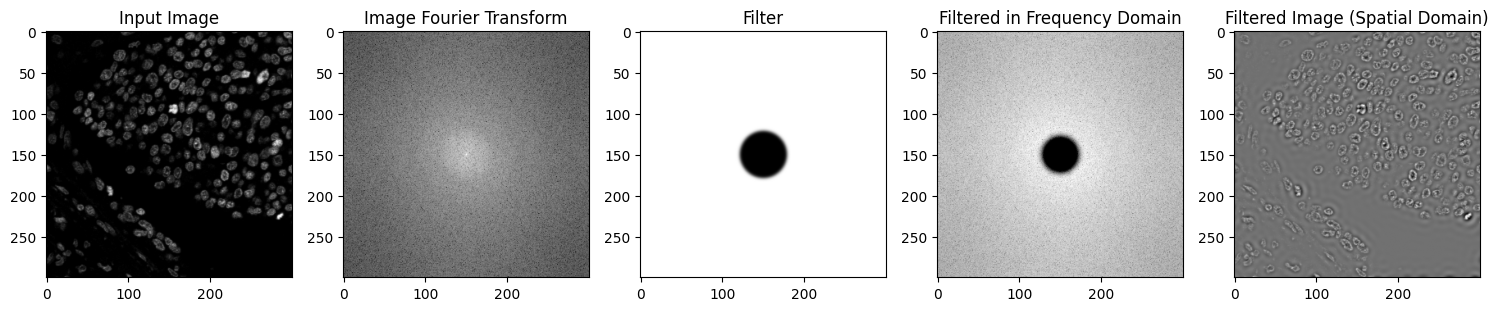

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from hdaf_filter import hdaf
from hdaf_filter import input_output

# This is the basics of how to do filtering on an image


# --- Load image ---
# file_path = "" # <- Here you set the path to your image
# img = tifffile.imread(file_path)

!wget https://github.com/paul-hernandez-herrera/hdaf_filtering/raw/03e58207ecc8c011b66325dc1e60912dd372ead8/test_data/2d/Cells_01.tif
img = input_output.imread('Cells_01.tif')
# plt.imshow(img, cmap='gray')

# --- Apply HDAF filtering ---
obj = hdaf.filt(img)

# Get high-pass filter and Fourier transform of the image
high_pass_filter = obj.get_filter('high_pass', 3.0)
img_fourier = obj.img_FT

# Center the filter and Fourier transform
filter_centered = np.fft.fftshift(high_pass_filter)
fourier_centered = np.fft.fftshift(img_fourier)

# Apply the filter in the frequency domain
filtered_fourier = filter_centered * fourier_centered

# Inverse Fourier transform to obtain the filtered image in spatial domain
filtered_img = np.real(np.fft.ifftn(np.fft.ifftshift(filtered_fourier)))

# --- Plot results ---
fig, axs = plt.subplots(1, 5, figsize=(15, 15))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Input Image')

axs[1].imshow(np.log(np.abs(fourier_centered[0]) + 1), cmap='gray')
axs[1].set_title('Image Fourier Transform')

axs[2].imshow(filter_centered[0], cmap='gray')
axs[2].set_title('Filter')

axs[3].imshow(np.log(np.abs(filtered_fourier[0]) + 1), cmap='gray')
axs[3].set_title('Filtered in Frequency Domain')

axs[4].imshow(filtered_img[0], cmap='gray')
axs[4].set_title('Filtered Image (Spatial Domain)')

plt.tight_layout()
plt.show()

In [ ]:
# Apply Filtering to my data

# Compute loss on different Frequencies

- https://github.com/pdebench/PDEBench/blob/main/pdebench/models/metrics.py#L257C5-L296C1

- Visualize Samples @ different resolutions + frequencies (ground truth vs. model predictions)

- Compute FrMSE loss

In [24]:
df = pd.DataFrame(
    columns=['train_resolution', 'test_resolution', 'loss_type', 'loss'],
)

for train_resolution in [16]:
    # get data
    train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000,
        # batch_size=16,
        train_resolution=train_resolution,
        test_resolutions=[16, 32, 64, 128],
        n_tests=[100, 100, 100, 100],
        # test_batch_sizes=[32, 32, 32, 32],
    )

    # incrementally vary modes
    incremental = True
    starting_modes = (16, 16)
    if incremental:
        starting_modes = (2, 2)

    # Set up model
    model = FNO(
        max_n_modes=(16, 16),
        n_modes=starting_modes,
        hidden_channels=32,
        in_channels=1,
        out_channels=1,
    )
    model = model.to(device)
    n_params = count_model_params(model)

    # optimizer + data
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    data_transform = IncrementalDataProcessor(
        in_normalizer=None,
        out_normalizer=None,
        device=device,
        subsampling_rates=[2, 1],
        dataset_resolution=16,
        dataset_indices=[2, 3],
        epoch_gap=10,
        verbose=True,
    )

    data_transform = data_transform.to(device)

    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    train_loss = h1loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}
    print('\n### N PARAMS ###\n', n_params)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # Finally pass all of these to the Trainer
    trainer = IncrementalFNOTrainer(
        model=model,
        n_epochs=20,
        data_processor=data_transform,
        device=device,
        verbose=False,
        incremental_loss_gap=False,
        incremental_grad=True,
        incremental_grad_eps=0.9999,
        incremental_loss_eps=0.001,
        incremental_buffer=5,
        incremental_max_iter=1,
        incremental_grad_max_iter=2,
    )

    # train
    end_stats = trainer.train(
        train_loader,
        test_loaders,
        optimizer,
        scheduler,
        regularizer=False,
        training_loss=train_loss,
        eval_losses=eval_losses,
    )

    # save stats
    for k, v in end_stats.items():
        s = k.split('_')

        if 'h1' in s or ('l2' in s):
            row = {
                'train_resolution': train_resolution,
                'test_resolution': s[0],
                'loss_type': s[1],
                'loss': v.item(),
            }
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f08a7ca2410>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f08a7ca2410>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f08a7ca1ae0>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


/tmp/ipykernel_1033509/2457714951.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


In [27]:
model = trainer.model
model = model.to(device)
model = model.eval()
data_transform = data_transform.to(device)
for _idx, sample in enumerate(test_loaders[128]):  # resolution 32
    # print(sample['y'].shape)  # bs, 1 time step, x_dim, y_dim
    model_input = data_transform.preprocess(sample)
    # print(sample)
    with torch.no_grad():
        # with torch.autocast(device_type=device.type):
        out = model(**model_input)
        # out = model(x=sample['x'])

In [14]:
trainer.eval_one_batch(sample, eval_losses)

({'h1': tensor(1.0727, device='cuda:0', grad_fn=<SqueezeBackward0>),
  'l2': tensor(0.5533, device='cuda:0', grad_fn=<SqueezeBackward0>)},
 None)

In [15]:
eval_losses

{'h1': <neuralop.losses.data_losses.H1Loss at 0x7f08a7ca2c20>,
 'l2': <neuralop.losses.data_losses.LpLoss at 0x7f08a7ca36a0>}

In [16]:
out.shape

torch.Size([4, 1, 32, 32])

In [28]:
def frmse_2d(
    pred: torch.Tensor,
    target: torch.Tensor,
    scaling_factors: tuple(int, int) = (1.0, 1.0),
    i_low: int = 4,
    i_high: int = 12,
) -> torch.Tensor:
    """Loss on diffrent frequencies."""
    # initial_step = 1
    # pred = pred[..., initial_step:, :]
    # target = target[..., initial_step:, :]

    print(pred.shape)

    # pred = pred.permute(0, 4, 1, 2, 3)
    # target = target.permute(0, 4, 1, 2, 3)
    idxs = target.size()
    nb, nt = idxs[0], idxs[1]

    lx, ly = scaling_factors

    pred_freq = torch.fft.fftn(pred, dim=[2, 3])
    target_freq = torch.fft.fftn(target, dim=[2, 3])
    nx, ny = idxs[2:4]
    _err_freq = torch.abs(pred_freq - target_freq) ** 2

    err_freq = torch.zeros([nb, min(nx // 2, ny // 2), nt]).to(device)

    for i in range(nx // 2):
        for j in range(ny // 2):
            it = math.floor(math.sqrt(i**2 + j**2))
            if it > min(nx // 2, ny // 2) - 1:
                continue
            err_freq[:, it] += _err_freq[:, :, i, j]

    _err_freq = torch.sqrt(torch.mean(err_freq, axis=0)) / (nx * ny) * lx * ly
    print(f'{_err_freq.shape=}')
    err_freq = torch.zeros([3, nt]).to(device)
    print(f'{err_freq.shape=}')
    # low freq
    err_freq[0] += torch.mean(_err_freq[:i_low, :], dim=0)

    # middle freq
    err_freq[1] += torch.mean(_err_freq[i_low:i_high, :], dim=0)

    # high freq
    err_freq[2] += torch.mean(_err_freq[i_high:, :], dim=0)

    return err_freq


model = trainer.model
frmse_2d(pred=out, target=sample['y'])

torch.Size([4, 1, 128, 128])
_err_freq.shape=torch.Size([64, 1])
err_freq.shape=torch.Size([3, 1])


tensor([[0.0307],
        [0.0095],
        [0.0032]], device='cuda:0')

**Why does highest frequency info have the lowest loss? I would have expected the opposite. FM paper has the same trend? PDE bench has the same trend. Is there just not much high frequency information? Am I missing something (Do I have my understanding reversed)**


- Error on high frequency componenet should be scaled by the energy in the high frequency component
- Plot the High, medium, low frequency power spectrum (show that there is transition between the different bands)
- https://arxiv.org/pdf/2503.02113

Questions:
- fRMSE: RMSE in fourier space -- is it equivalent to compute loss in fourier space? Or should we filter different frequency bands and compute loss directly in the time domain? Why pick one over the other

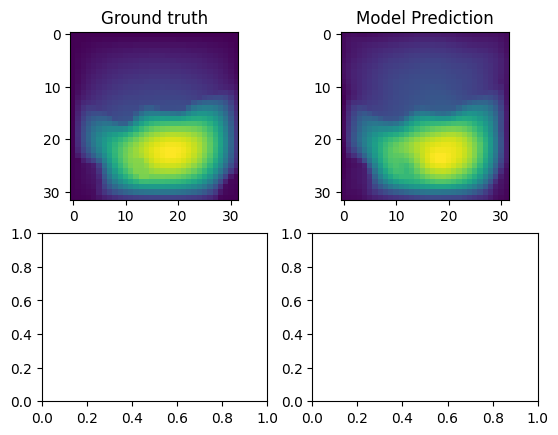

In [23]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(sample['y'][0, 0, :, :].to('cpu'))
axs[0, 0].set_title('Ground truth')
axs[0, 1].imshow(out[0, 0, :, :].to('cpu'))
axs[0, 1].set_title('Model Prediction')

pred_freq = torch.fft.fftn(out, dim=[2, 3])
target_freq = torch.fft.fftn(sample['y'], dim=[2, 3])

# axs[1,0].imshow(target_freq[0,0,:,:].to("cpu"))
# axs[1,0].set_title("Ground truth")
# axs[1,1].imshow(pred_freq[0,0,:,:].to("cpu"))
# axs[1,1].set_title("Model Prediction")